## Sine Generator Using GANs

In [96]:
import numpy as np
import matplotlib as plt
Z_DIM = 1 #Size of input for Generator
G_HIDDEN = 10 #Size of the hidden layers in the Generator network
X_DIM = 10 #Size of input for Discriminator
D_HIDDEN = 10 #Size of the hidden layers in the Discriminator network

step_size_G = 0.01 #AKA Learning Rate
step_size_D = 0.01
ITER_NUM = 100000

GRADIENT_CLIP = 0.2
WEIGHT_CLIP = 0.25

In [97]:
def get_samples(random = True):
    if random:
        x0 = np.random.uniform(0, 1)
        freq = np.random.uniform(1.2, 1.5)
        mult = np.random.uniform(0.5, 0.8)
    else:
        x0 = 0
        freq = 0.2
        mult = 1
    signal = [mult*np.sin(x0+freq*i) for i in range(X_DIM)]
    return np.array(signal)

In [98]:
def ReLU(x):
    return np.maximum(x, 0.)

def dReLU(x):
    return ReLU(x)

def LeakyReLU(x, k=0.2):
    return np.where(x>=0,x,x*k)

def dLeakyReLU(x, k=0.2):
    return np.where(x>=0,1.,k)

def Tanh(x):
    return np.tanh(x)

def dTanh(x):
    return 1. - Tanh(x)**2

def Sigmoid(x):
    return 1. / (1. +np.exp(-x))

def dSigmoid(x):
    return Sigmoid(x)*(1. - Sigmoid(x))

In [99]:
def weight_initializer(in_channels, out_channels):
    scale = np.sqrt(2. /(in_channels+out_channels))
    return np.random.uniform(-scale,scale,(in_channels, out_channels))

In [100]:
class LossFunc(object):
    def __int__(self):
        self.logit = None
        self.label = None
    def forward(self, logit, label):
        if logit[0,0]<1e-7:
            logit[0,0]=1e-7
        if 1. -logit[0,0] < 1e-7:
            logit[0,0] = 1. - 1e-7
        self.logit = logit
        self.label = label
        return - (label*np.log(logit)+(1-label)*np.log(1-logit))
    def backward(self):
        return (1-self.label) / (1-self.logit) - self.label / self.logit

In [101]:
class Generator(object):
    def __init__(self):
        self.z = None
        self.w1 = weight_initializer(Z_DIM, G_HIDDEN)
        self.b1 = weight_initializer(1, G_HIDDEN)
        self.x1 = None
        self.w2 = weight_initializer(G_HIDDEN, G_HIDDEN)
        self.b2 = weight_initializer(1, G_HIDDEN)
        self.x2 = None
        self.w3 = weight_initializer(G_HIDDEN, X_DIM)
        self.b3 = weight_initializer(1, X_DIM)
        self.x3 = None
        self.x = None
    def forward(self, inputs): #ReLU in Hidden layers and Tanh in output
        self.z = inputs.reshape(1, Z_DIM)
        self.x1 = np.matmul(self.z, self.w1) + self.b1
        self.x1 = ReLU(self.x1)
        self.x2 = np.matmul(self.x1, self.w2) + self.b2
        self.x2 = ReLU(self.x2)
        self.x3 = np.matmul(self.x2, self.w3)+self.b3
        self.x = Tanh(self.x3)
        return self.x
    def backward(self, outputs):
        #Derivative with respect to output
        delta = outputs
        delta *= dTanh(self.x)
        #Derivative with respect to w3
        d_w3 = np.matmul(np.transpose(self.x2),delta)
        #Derivative with respect to b3
        d_b3 = delta.copy()
        #Derivative with respect to x2
        delta = np.matmul(delta, np.transpose(self.w3))
        #Update w3
        if (np.linalg.norm(d_w3)>GRADIENT_CLIP):
            d_w3 = GRADIENT_CLIP/np.linalg.norm(d_w3)*d_w3
        self.w3 -= step_size_G*d_w3
        self.w3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w3))
        #Update b3
        self.b3 -=step_size_G*d_b3
        self.b3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP,self.b3))
        delta *= dReLU(self.x2)
        #Derivative with respect to w2
        d_w2 = np.matmul(np.transpose(self.x1),delta)
        #Derivative with respect to b2
        d_b2 = delta.copy()
        #Derivative with respect to x1
        delta = np.matmul(delta,np.transpose(self.w2))
        #Update w2
        if (np.linalg.norm(d_w2)>GRADIENT_CLIP):
            d_w2 = GRADIENT_CLIP/np.linglang.norm(d_w2)*d_w2
        self.w2 -=step_size_G*d_w2
        self.w2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w2))
        #Update b2
        self.b2 -= step_size_G * d_b2
        self.b2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP,self.b2))
        delta *= dReLU(self.x1)
        #Derivative with respect to w1
        d_w1 = np.matmul(np.transpose(self.z),delta)
        #Derivative with respect to b1
        d_b1 = delta.copy()
        #No need to calculate derivative with respect to z
        #Update w1
        if (np.linalg.norm(d_w1)>GRADIENT_CLIP):
            d_w1 = GRADIENT_CLIP/np.linlang.norm(d_w1)*d_w1
        self.w1 -= step_size_G * d_w1
        self.w1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w1))
        #Update b1
        self.b1 -= step_size_G * d_b1
        self.b1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b1))
        return delta

In [102]:
class Discriminator(object):
    def __init__(self):
        self.x = None
        self.w1 = weight_initializer(X_DIM, D_HIDDEN)
        self.b1 = weight_initializer(1, D_HIDDEN)
        self.y1 = None
        self.w2 = weight_initializer(D_HIDDEN, D_HIDDEN)
        self.b2 = weight_initializer(1, D_HIDDEN)
        self.y2 = None
        self.w3 = weight_initializer(D_HIDDEN, 1)
        self.b3 = weight_initializer(1,1)
        self.y3 = None
        self.y = None
    def forward(self, inputs):
        self.x = inputs.reshape(1, X_DIM)
        self.y1 = np.matmul(self.x, self.w1)+self.b1
        self.y1 = LeakyReLU(self.y1)
        self.y2 = np.matmul(self.y1, self.w2)+self.b2
        self.y2 = LeakyReLU(self.y2)
        self.y3 = np.matmul(self.y2, self.w3)+self.b3
        self.y = Sigmoid(self.y3)
        return self.y
    def backward(self, outputs, apply_grads=True):
        #Derivative with respect to output
        delta = outputs*dSigmoid(self.y)
        #Derivative with respect to w3
        d_w3 = np.matmul(np.transpose(self.y2),delta)
        #Derivative with respect to b3
        d_b3 = delta.copy()
        #Derivative with respect to y2
        delta = np.matmul(delta, np.transpose(self.w3))
        if apply_grads:
            #Update w3
            if np.linalg.norm(d_w3)>GRADIENT_CLIP:
                d_w3 = GRADIENT_CLIP/np.linalg.norm(d_w3)*d_w3
            self.w3+=step_size_D*d_w3
            self.w3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w3))
            #Update b3
            self.b3 += step_size_D*d_b3
            self.b3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b3))
        delta *= dLeakyReLU(self.y2)
        #Derivative with respect to w2
        d_w2 = np.matmul(np.transpose(self.y1),delta)
        #Derivative with respect to b2
        d_b2 = delta.copy()
        #Derivative with respect to y1
        delta = np.matmul(delta, np.transpose(self.w2))
        if apply_grads:
            #Update w2
            if np.linalg.norm(d_w2)>GRADIENT_CLIP:
                d_w2 = GRADIENT_CLIP/np.linalg.norm(d_w2)*d_w2
            self.w2 += step_size_D*d_w2
            self.w2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w2))
            #Update b2
            self.b2 += step_size_D*d_b2
            self.b2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b2))
        delta *= dLeakyReLU(self.y1)
        #Derivative with respect to w1
        d_w1 = np.matmul(np.transpose(self.x),delta)
        #Derivative with respect to b1
        d_b1 = delta.copy()
        #Derivative with respect to x
        delta = np.matmul(delta, np.transpose(self.w1))
        #Update w1
        if apply_grads:
            if np.linalg.norm(d_w1)>GRADIENT_CLIP:
                d_w1 = GRADIENT_CLIP/np.linalg.norm(d_w1)*d_w1
            self.w1+=step_size_D*d_b1
            self.b1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b1))
        return delta

In [103]:
G = Generator()
D = Discriminator()
criterion = LossFunc()

In [104]:
real_label = 1
fake_label = 0

In [105]:
for itr in range(ITER_NUM):
    #Update D with real data
    x_real = get_samples(True)
    y_real = D.forward(x_real)
    loss_D_r = criterion.forward(y_real, real_label)
    d_loss_D = criterion.backward()
    D.backward(d_loss_D)
    
    #Update D with fake data
    z_noise = np.random.randn(Z_DIM)
    x_fake = G.forward(z_noise)
    y_fake = D.forward(x_fake)
    loss_D_f = criterion.forward(y_fake, fake_label)
    d_loss_D = criterion.backward()
    D.backward(d_loss_D)
    
    #Update G with fake data
    y_fake_r = D.forward(x_fake)
    loss_G = criterion.forward(y_fake_r, real_label)
    d_loss_G = D.backward(loss_G, apply_grads = False)
    G.backward(d_loss_G)
    loss_D = loss_D_r + loss_D_f
    if itr % 100 == 0:
        print('{} {} {}'.format(loss_D_r.item((0, 0)), loss_D_f.item((0,0)), loss_G.item((0,0))))

1.1040827660139227 0.57820425593928 0.8200917090448976
0.8527528344040642 0.5650886132171442 0.8368428747552672
0.863418688956337 0.5563703386618488 0.8484170322960495
0.8735646113754705 0.5444087354624897 0.8645613315365107
0.8684219767237656 0.5410990196025782 0.8690788402477795
0.9048623849714982 0.5369997853247763 0.8747112278364373
0.9007285283652083 0.5315407737287626 0.8823564650895585
0.918831526260466 0.5307016393432019 0.8835392636974437
0.9176733099777423 0.5283503375216939 0.8868597980554661
0.8720601261779876 0.527208853891121 0.8884897247172827
0.9107783214705036 0.5208715216400899 0.8975914807265608
0.9238556096019598 0.5143737467640337 0.9073320597624406
0.9218013858961895 0.5043846420309003 0.9221765252518402
0.8949814410384421 0.48812764215866267 0.9471806260267611
0.899717221567918 0.49162053799993566 0.9417168088132506
0.9084269939357402 0.49360433593028125 0.9386001348304676
0.9389112968578848 0.4626726850451071 0.9878990773684634
0.9472364475950366 0.4738987192681

1.0169601559075296 0.4509451116529562 1.0078316692824942
1.0051175954745686 0.45373081310548385 1.0027189610448317
1.0215792988914085 0.4532845431228041 1.0035515764247425
1.0017259389719648 0.4507948170002631 1.008783200790233
0.9962798537402925 0.4562059434103336 0.9982523563676095
0.9902123060705934 0.45497935844867066 1.0011193917529244
0.9987860229769783 0.4576684577041748 0.9959268047074218
1.0019077078994107 0.4519389646880668 1.007309791540042
0.9799606666705529 0.4521834103139708 1.006395785724846
1.0038337275779554 0.45223988010306304 1.0069811185096564
1.007908186250904 0.451852168598149 1.0069990161328
0.9745013525189745 0.45027340022831114 1.0067865657912796
0.9808246240814859 0.4521917905712015 1.0064964912272663
1.012915526686514 0.4542120974494924 1.0003078314182947
1.0204449292613236 0.45406556865725795 1.0012330154083684
0.9982319666740955 0.4561352009230088 0.9980707423732267
0.9997844566476153 0.4509776529935146 1.0052189062752288
0.9860923811346749 0.45955155053413

0.8894727824945208 0.5333220666114858 0.8783196035414756
0.9012265386262268 0.5218425630045889 0.8967792875248687
0.900664841821394 0.5118867714894914 0.9093363700467637
0.9000011141582667 0.5175005224365856 0.9024413664431931
0.8964546510123411 0.5210680821215234 0.8969060943070647
0.8942115773035024 0.5225999784265832 0.8950150377249991
0.9021193236903382 0.5209972005012374 0.8976773307752758
0.9162031813165222 0.5205752153839351 0.8986537429334829
0.9195714745248034 0.5157879142906299 0.9051088922406856
0.9019594831725126 0.5202491110832478 0.8970396262566634
0.8978096886154368 0.5203262890087696 0.8985295242208188
0.9002698628132737 0.5176703910066253 0.9028262337115477
0.9045138570812989 0.5163119154620566 0.9047551028294083
0.9047837109566834 0.5152854563968089 0.9055607891902744
0.902241392077669 0.5207944369837322 0.8967969186402046
0.9053119798011962 0.5158963606509402 0.9056613677110739
0.9075733638595513 0.5141511980506897 0.908009503713237
0.908987729457296 0.51033527321049

0.9675394883842906 0.47707592905616775 0.96518225283975
0.9633254094146326 0.4841760783420257 0.9523487072138714
0.9701551031357125 0.4714780338127263 0.9714817394254294
0.9656518334726698 0.47578491104865106 0.9676385639995371
0.9670484376232374 0.48001475991695747 0.9593762528835853
0.9691419635993864 0.48302851467883196 0.9539313339112006
0.9792114716904362 0.4769518206265995 0.9660465259436541
0.9713519152426683 0.4767920624546644 0.9661316779906582
0.9597608265158543 0.482229822095044 0.9540436630419581
0.9601575502766729 0.48058501259701114 0.9601027286254652
0.9636778257585921 0.4776485418934423 0.9647453296363202
0.9660571569889791 0.4778800919702165 0.964553123974317
0.9587827757235905 0.4818294272875196 0.9562365925860772
0.95142752199051 0.48531555491242107 0.9512634736102346
0.9654365388264041 0.4782072815626448 0.9631168431719757
0.9615587445087779 0.4803785270260475 0.9590585057171981
0.9667722199052307 0.4788578296998355 0.9627032246625713
0.9625338288199211 0.4788319856

0.9635004659170291 0.4814120923877061 0.9580487228803047
0.9429817929313542 0.48246329111180514 0.9554112850738862
0.9643040179364327 0.48210676138479586 0.9561314928044848
0.9642964380789211 0.48105093501581 0.9572361788152408
0.9705116350493842 0.4775346018238203 0.9650451239846048
0.9596935217008935 0.479201728352101 0.9593206189938713
0.965010134903254 0.4848345020681411 0.9511578837283475
0.9683421906557707 0.4848037490048695 0.9519381603128066
0.9713680843018029 0.4705023540256406 0.9717992531827527
0.9682313592892756 0.48165600920141444 0.9566980942169843
0.9691329827017626 0.4835187664904028 0.9541643113507975
0.966369139665731 0.4823982657197892 0.9551438040180693
0.9722333430094467 0.47364749029909065 0.9647113444958765
0.9728535157790298 0.4737925035596022 0.9710729193401233
0.968012186918286 0.4814350687612709 0.9563101241511198
0.9703929580214988 0.4815865250712835 0.9564005143088712
0.9667239998637669 0.4751895219113087 0.9680942627983108
0.9671157220278326 0.482049554800

0.9617024887492521 0.4811400522080576 0.9593475614610819
0.9628786198617119 0.48109173101026725 0.9588125449539235
0.9629107687957991 0.4834367963617149 0.9546206154285127
0.9584084483573865 0.4811044166243042 0.9585929244870754
0.9621462916533295 0.48222554445033433 0.955008807577607
0.9868452663089203 0.48019309134084515 0.9608186080552232
0.9532501061242455 0.48123524583786303 0.9589228770969612
0.9526956036675305 0.48633828016320046 0.9497759994299194
0.9580542314145045 0.48296338512835446 0.9562365634628249
0.9617139938818252 0.48197595342388116 0.9571049768548726
0.9578644224550625 0.4856363710886419 0.9500913973599464
0.9599234792447636 0.476244713954553 0.9611292774365829
0.9616077688043987 0.48304104082127375 0.9558875679405572
0.9501609491003242 0.48429299038268064 0.9492248259349482
0.9457117000270493 0.48471518111469103 0.9498600036483458
0.9650704912819569 0.47813085164100977 0.9602976682937503
0.9664223031674608 0.47930213846734643 0.961921018089218
0.9614288510751824 0.4

0.940924327503908 0.48375704276703346 0.9547519074439095
0.9726622005753794 0.4835091482441521 0.9553153607779259
0.9535346062532669 0.48778361927077857 0.9455733852887607
0.9911079060383087 0.48629923498015454 0.9501774200781685
0.9211156412822256 0.48646088345911204 0.9469703794224862
0.9567703954398501 0.4882801861306162 0.944743174798942
0.9503924961325511 0.48560131264720763 0.9520192823286451
0.945148727829387 0.4903665145596221 0.9416765475266643
0.9506855440062989 0.48671120577204363 0.9499587717730483
0.9537229951455302 0.48782936824315837 0.9488009708876826
0.9509870483997566 0.4850892649837288 0.952888576484616
0.9287440760256018 0.48422837310037276 0.950396398146438
0.9431957735909251 0.4856095643642037 0.9521146634906058
0.9502555865443307 0.4715037622586696 0.9688886637075624
0.9533245279237649 0.48633684461405596 0.9508594605588917
0.9510847532536874 0.4987112853324658 0.9300358338888783
0.9404327088561166 0.4946106526297585 0.9355969079009699
0.9522255458221648 0.488738

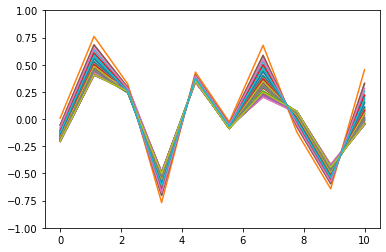

In [106]:
import matplotlib.pyplot as plt
x_axis = np.linspace(0, 10, 10)
for i in range(50):
    z_noise = np.random.randn(Z_DIM)
    x_fake = G.forward(z_noise)
    plt.plot(x_axis, x_fake.reshape(X_DIM))
plt.ylim((-1,1))
plt.show()